In [145]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, RepeatedKFold, cross_val_score
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics, svm
from sklearn.feature_selection import SelectKBest, f_regression

In [146]:
# Run the data preprocessing notebook
data = pd.read_csv('docs/Breast_Cancer_Dataset.csv')

In [147]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Data Preparation

In [148]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [149]:
data.shape

(569, 33)

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [151]:
# Drop ID Column
data = data.drop(['id','Unnamed: 32'], axis=1)

In [152]:
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
data['diagnosis']

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [153]:
# Check if Duplicated
data.duplicated().value_counts()

False    569
Name: count, dtype: int64

In [154]:
# There are not Na's in the data
for column in data:
    print(data[column].isna().value_counts())
    print(" ")

diagnosis
False    569
Name: count, dtype: int64
 
radius_mean
False    569
Name: count, dtype: int64
 
texture_mean
False    569
Name: count, dtype: int64
 
perimeter_mean
False    569
Name: count, dtype: int64
 
area_mean
False    569
Name: count, dtype: int64
 
smoothness_mean
False    569
Name: count, dtype: int64
 
compactness_mean
False    569
Name: count, dtype: int64
 
concavity_mean
False    569
Name: count, dtype: int64
 
concave points_mean
False    569
Name: count, dtype: int64
 
symmetry_mean
False    569
Name: count, dtype: int64
 
fractal_dimension_mean
False    569
Name: count, dtype: int64
 
radius_se
False    569
Name: count, dtype: int64
 
texture_se
False    569
Name: count, dtype: int64
 
perimeter_se
False    569
Name: count, dtype: int64
 
area_se
False    569
Name: count, dtype: int64
 
smoothness_se
False    569
Name: count, dtype: int64
 
compactness_se
False    569
Name: count, dtype: int64
 
concavity_se
False    569
Name: count, dtype: int64
 
concave point

In [155]:
# Data to be Normalized
numerical_cols = []
for column in data:
    stats= data[column].describe()
    if stats['min'] <-1.0 or stats['max']>1.0:
        numerical_cols.append(stats.name)
print(numerical_cols)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst']


In [156]:
def detect_outliers_and_normalize(data, numerical_cols):
    print(" Detecting outliers and visualizing the distribution of numerical variables:\n")

    outliers_info = {}

    for col in numerical_cols:
        # Calculate the Interquartile Range (IQR)
        Q1 = data[col].quantile(0.25)  # First quartile
        Q3 = data[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        num_outliers = len(outliers)
        outliers_info[col] = num_outliers

        # Display outlier information
        print(f"{col}: {num_outliers} outliers detected")

        # # Visualize the variable distribution with a boxplot
        # plt.figure(figsize=(8, 4))
        # plt.subplot(1, 2, 1)
        # plt.boxplot(data[col])
        # plt.title(f'Boxplot of {col}')

        # # Visualize with a histogram
        # plt.subplot(1, 2, 2)
        # plt.hist(data[col], bins=30, color='skyblue', edgecolor='black')
        # plt.title(f'Distribution of {col}')

        # plt.show()

    print("\n Summary of detected outliers:")
    for col, count in outliers_info.items():
        print(f"- {col}: {count} outliers")

    # Normalize numerical variables with StandardScaler
    scaler = StandardScaler().set_output(transform='pandas')
    transformed_data = scaler.fit_transform(data[numerical_cols])

    print("\n Numerical variables successfully normalized.")

    return transformed_data

In [157]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def delete_outliers_and_normalize(data, numerical_cols):
    print("✅ Detecting and removing outliers, then normalizing numerical variables:\n")

    outliers_info = {}
    clean_data = data.copy()

    for col in numerical_cols:
        # Calculate the Interquartile Range (IQR)
        Q1 = data[col].quantile(0.25)  # First quartile
        Q3 = data[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        num_outliers = len(outliers)
        outliers_info[col] = num_outliers

        # Remove outliers
        clean_data = clean_data[(clean_data[col] >= lower_bound) & (clean_data[col] <= upper_bound)]

        # Display outlier information
        print(f"{col}: {num_outliers} outliers detected and removed")

    print("\n📊 Summary of detected and removed outliers:")
    for col, count in outliers_info.items():
        print(f"- {col}: {count} outliers")

    # Normalize numerical variables after removing outliers
    scaler = StandardScaler().set_output(transform='pandas')
    normalized_data = scaler.fit_transform(clean_data[numerical_cols])

    print("\n📏 Numerical variables successfully normalized after outlier removal.")
    
    # Merge normalized data with non-numerical columns
    clean_data[numerical_cols] = normalized_data

    return clean_data


In [158]:
normalized_data= delete_outliers_and_normalize(data, numerical_cols)
normalized_data

✅ Detecting and removing outliers, then normalizing numerical variables:

radius_mean: 14 outliers detected and removed
texture_mean: 7 outliers detected and removed
perimeter_mean: 13 outliers detected and removed
area_mean: 25 outliers detected and removed
radius_se: 38 outliers detected and removed
texture_se: 20 outliers detected and removed
perimeter_se: 38 outliers detected and removed
area_se: 65 outliers detected and removed
radius_worst: 17 outliers detected and removed
texture_worst: 5 outliers detected and removed
perimeter_worst: 15 outliers detected and removed
area_worst: 35 outliers detected and removed
compactness_worst: 16 outliers detected and removed
concavity_worst: 12 outliers detected and removed

📊 Summary of detected and removed outliers:
- radius_mean: 14 outliers
- texture_mean: 7 outliers
- perimeter_mean: 13 outliers
- area_mean: 25 outliers
- radius_se: 38 outliers
- texture_se: 20 outliers
- perimeter_se: 38 outliers
- area_se: 65 outliers
- radius_worst: 

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
5,1,-0.300400,-0.745532,-0.171031,-0.361735,0.12780,0.17000,0.157800,0.08089,0.2087,...,0.162390,-0.180295,0.246661,0.079573,0.17910,2.492437,1.843038,0.17410,0.3985,0.12440
6,1,1.966863,0.365273,1.969436,2.137951,0.09463,0.10900,0.112700,0.07400,0.1794,...,2.407784,0.513344,2.450100,2.695728,0.14420,0.275271,0.898777,0.19320,0.3063,0.08368
7,1,0.192143,0.585877,0.270010,0.085890,0.11890,0.16450,0.093660,0.05985,0.2196,...,0.644195,0.598497,0.565231,0.549900,0.16540,1.192662,0.234008,0.15560,0.3196,0.11510
8,1,-0.085401,0.842815,0.113941,-0.172116,0.12730,0.19320,0.185900,0.09353,0.2350,...,0.168451,1.057966,0.370549,0.072612,0.17030,2.618517,1.864075,0.20600,0.4378,0.10720
10,1,1.095139,1.211354,0.992555,1.062406,0.08206,0.06669,0.032990,0.03323,0.1528,...,1.289632,1.616780,1.149275,1.315619,0.11810,-0.574934,-0.498681,0.09975,0.2948,0.08452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0,-1.195578,0.264055,-1.202247,-1.096232,0.10030,0.07504,0.005025,0.01116,0.1791,...,-1.298176,-0.334634,-1.324949,-1.113797,0.12650,-0.866077,-1.315217,0.02232,0.2262,0.06742
558,0,0.536142,1.066015,0.627815,0.437596,0.08473,0.13300,0.102900,0.03736,0.1454,...,0.165420,0.444157,0.357275,0.055058,0.10260,0.768804,0.825448,0.11050,0.2258,0.08004
560,0,0.325052,2.226131,0.338219,0.185806,0.09929,0.11260,0.044620,0.04304,0.1537,...,0.110877,1.490825,0.105075,-0.026053,0.12410,0.016477,-0.578622,0.10480,0.2250,0.08321
566,1,1.321865,2.467498,1.316255,1.330182,0.08455,0.10230,0.092510,0.05302,0.1590,...,1.225998,1.659356,1.277588,1.236928,0.11390,0.704935,0.669774,0.14180,0.2218,0.07820


In [138]:
normalized_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461 entries, 5 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              461 non-null    float64
 1   texture_mean             461 non-null    float64
 2   perimeter_mean           461 non-null    float64
 3   area_mean                461 non-null    float64
 4   smoothness_mean          461 non-null    float64
 5   compactness_mean         461 non-null    float64
 6   concavity_mean           461 non-null    float64
 7   concave points_mean      461 non-null    float64
 8   symmetry_mean            461 non-null    float64
 9   fractal_dimension_mean   461 non-null    float64
 10  radius_se                461 non-null    float64
 11  texture_se               461 non-null    float64
 12  perimeter_se             461 non-null    float64
 13  area_se                  461 non-null    float64
 14  smoothness_se            461 no

##### Feature selection

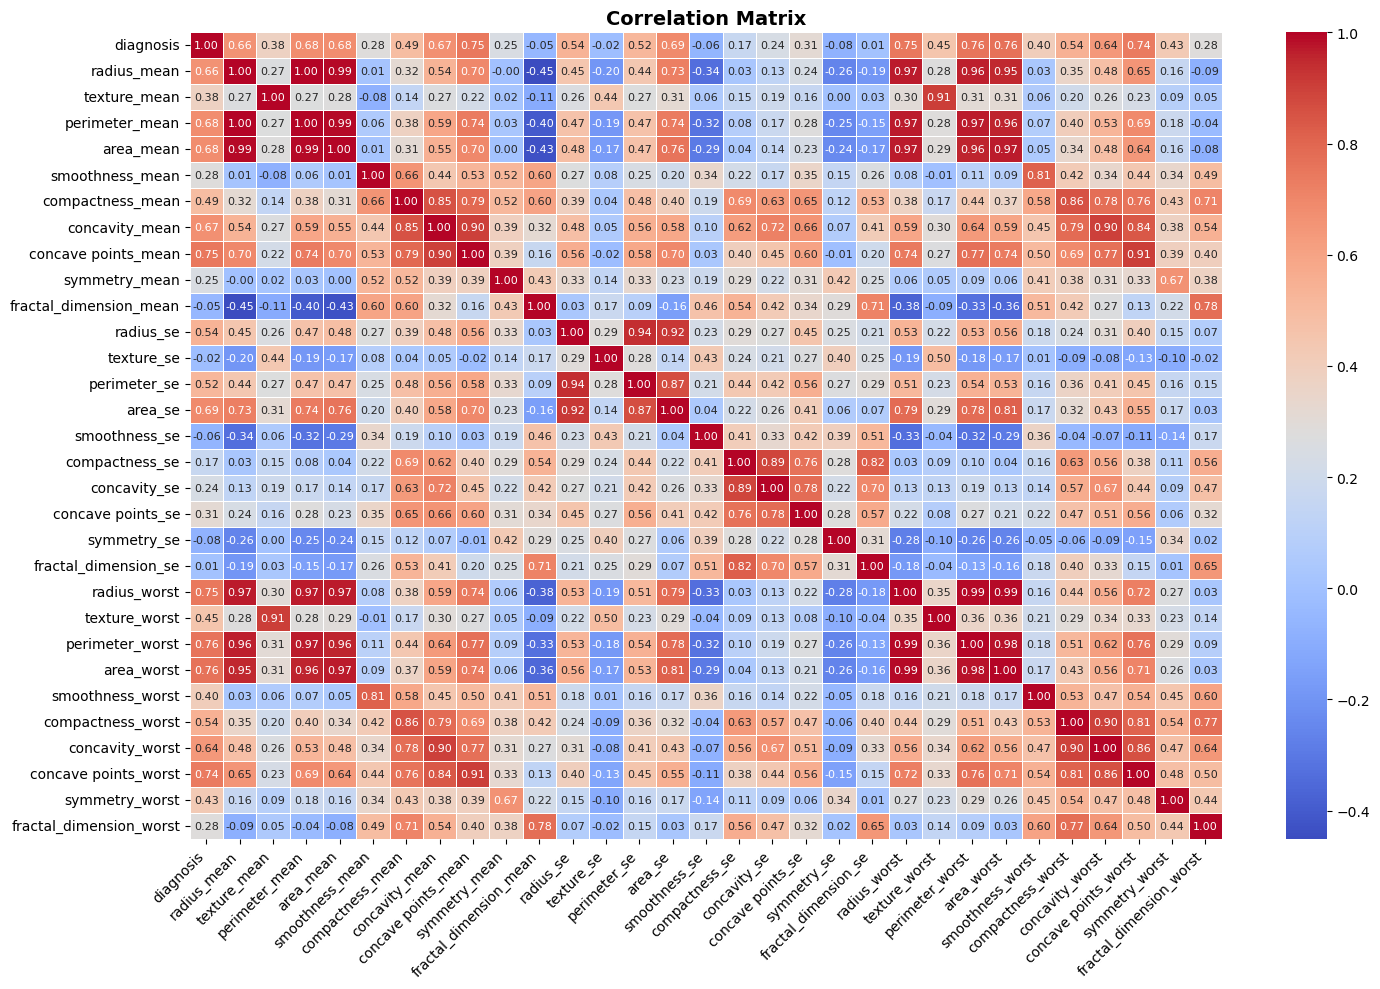

In [159]:
#calculate the correlation matrix
corr_matrix = normalized_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Varianza explicada por componente:
[5.84018280e-01 1.60323398e-01 1.10530829e-01 9.10703450e-02
 2.58866724e-02 9.05186639e-03 7.17406874e-03 4.25414432e-03
 3.43733218e-03 1.76256178e-03 1.19528844e-03 7.79703684e-04
 1.57315333e-04 1.35237190e-04 1.01818165e-04 3.96445400e-05
 2.50533173e-05 1.63253105e-05 1.24622571e-05 8.64320371e-06
 6.84911496e-06 4.51109986e-06 3.36121172e-06 1.55682326e-06
 1.09769055e-06 6.74416060e-07 5.10928024e-07 1.83775869e-07
 1.43545133e-07 9.34731979e-08 2.87178405e-08]


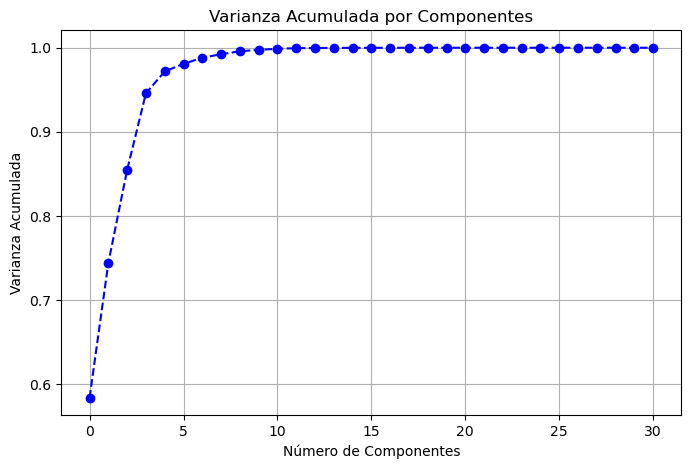

Número óptimo de componentes para explicar el 95% de la varianza: 5

Primeras filas de los datos reducidos:
        PC1       PC2       PC3       PC4       PC5
0  0.767503 -0.579346 -1.297589  2.869894  0.111249
1  5.974300 -1.298562  0.233704 -0.884023 -0.204490
2  2.647646  1.637899  1.174767  1.194346 -0.569104
3  1.414895  0.717698 -2.386083  2.121603 -0.386261
4  2.988286  0.651464 -0.211897 -2.046288 -0.431338

Pesos de cada componente (Loadings):
                              PC1       PC2       PC3       PC4       PC5
diagnosis                0.122268  0.022350 -0.041756  0.046360 -0.057588
radius_mean              0.320371 -0.174418 -0.023012 -0.209121  0.165130
texture_mean             0.142821  0.461572 -0.308667 -0.263690 -0.439751
perimeter_mean           0.325112 -0.164940 -0.034803 -0.161409  0.174654
area_mean                0.323601 -0.155054  0.002190 -0.208402  0.144907
smoothness_mean          0.000769  0.000708  0.000365  0.005681  0.002434
compactness_mean        

In [160]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Usar los datos normalizados
X_scaled = normalized_data

# Inicializar PCA para analizar todos los componentes
pca = PCA(n_components=None)

# Ajustar PCA a los datos normalizados
X_pca = pca.fit_transform(X_scaled)

# Mostrar varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Varianza explicada por componente:\n{explained_variance_ratio}')

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
plt.title('Varianza Acumulada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

# Calcular varianza acumulada
cumulative_variance = np.cumsum(explained_variance_ratio)

# Número de componentes que explican al menos el 95% de la varianza
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Número óptimo de componentes para explicar el 95% de la varianza: {n_components}')

# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X_scaled)

# Convertir el resultado a DataFrame si es necesario
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
print("\nPrimeras filas de los datos reducidos:")
print(X_reduced_df.head())

# Mostrar pesos (loadings) de cada componente
loadings = pd.DataFrame(
    pca_opt.components_.T,
    index=X_scaled.columns,
    columns=[f'PC{i+1}' for i in range(n_components)]
)
print("\nPesos de cada componente (Loadings):")
print(loadings)


In [162]:
from sklearn.model_selection import train_test_split


y = normalized_data['diagnosis'] 

# Dividir datos para entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

Tamaño del conjunto de entrenamiento: (322, 5)
Tamaño del conjunto de prueba: (139, 5)


##### KNN

Test accuracy with default KNN (k=5): 0.9032
Best k: 4


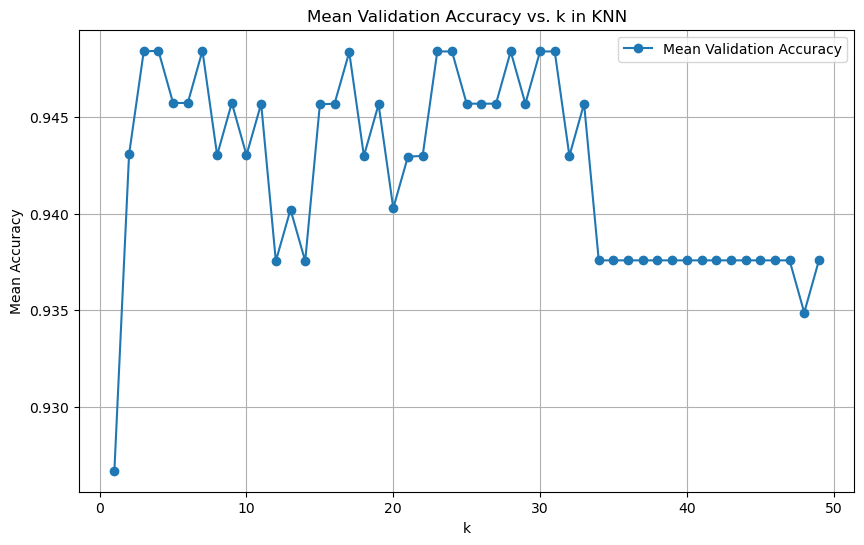

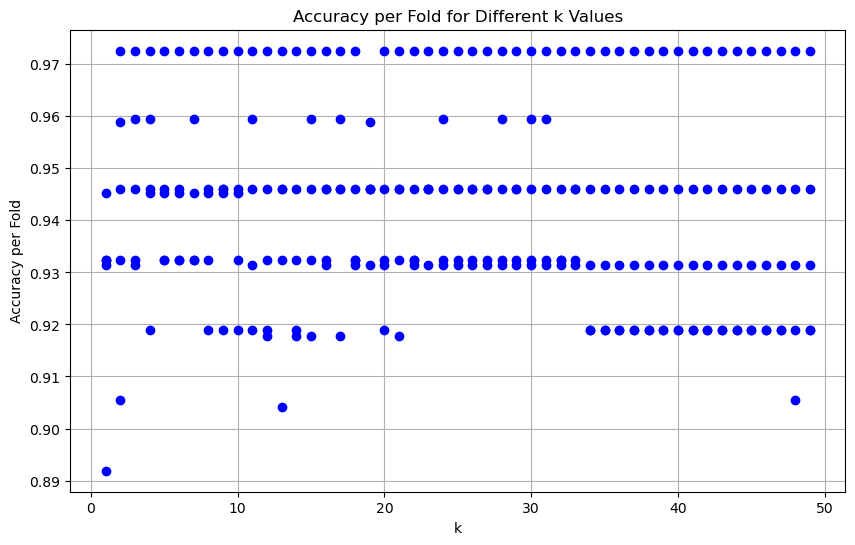

Test accuracy with k=4: 0.9032
Test accuracy with Weighted KNN and k=4: 0.8817


In [163]:
# Importar bibliotecas necesarias
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt

# Dividir datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_reduced_df, y, test_size=0.2, random_state=42)

# Inicializar modelo KNN con valores por defecto (k=5)
knn_default = KNeighborsClassifier()
knn_default.fit(X_train, y_train)
test_accuracy_default = knn_default.score(X_test, y_test)
print(f"Test accuracy with default KNN (k=5): {test_accuracy_default:.4f}")

# Inicializar variables para almacenar resultados
k_values = range(1, 50)
cv_accuracies = []

# Almacenar precisiones de cada fold para análisis
all_folds_accuracies = {k: [] for k in k_values}
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Validación cruzada para distintos valores de k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    fold_accuracies = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
    all_folds_accuracies[k] = fold_accuracies
    cv_accuracies.append(fold_accuracies.mean())

# Encontrar el mejor valor de k (con la mejor precisión promedio)
best_k = k_values[np.argmax(cv_accuracies)]
print(f"Best k: {best_k}")

# Graficar la precisión media en validación cruzada para distintos valores de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_accuracies, marker='o', label='Mean Validation Accuracy')
plt.xlabel('k')
plt.ylabel('Mean Accuracy')
plt.title('Mean Validation Accuracy vs. k in KNN')
plt.legend()
plt.grid(True)
plt.show()

# Graficar precisión por fold para distintos valores de k
plt.figure(figsize=(10, 6))
for k in k_values:
    plt.plot([k] * len(all_folds_accuracies[k]), all_folds_accuracies[k], 'bo', label=f'k={k}' if k == 1 else "")
plt.xlabel('k')
plt.ylabel('Accuracy per Fold')
plt.title('Accuracy per Fold for Different k Values')
plt.grid(True)
plt.show()

# Entrenar modelo con el mejor k y evaluar en el conjunto de prueba
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
test_accuracy = best_knn.score(X_test, y_test)
print(f"Test accuracy with k={best_k}: {test_accuracy:.4f}")

# Mejorar con KNN Ponderado (Weighted KNN)
weighted_knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
weighted_knn.fit(X_train, y_train)
weighted_test_accuracy = weighted_knn.score(X_test, y_test)
print(f"Test accuracy with Weighted KNN and k={best_k}: {weighted_test_accuracy:.4f}")


##### Decision Tree

✅ Best max_depth: 1
📊 Best cross-validated accuracy: 0.9429


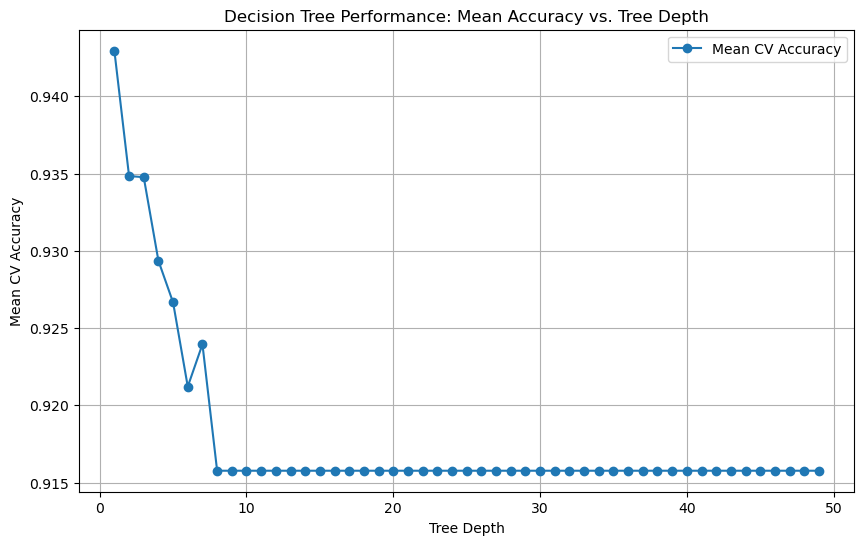

🎯 Test accuracy with max_depth=1: 0.8817


In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Set up KFold Cross-Validation
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for max_depth
param_grid = {'max_depth': np.arange(1, 50)}  # Test depths from 1 to 50

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)  # Changed from train_X, train_Y to X_train, y_train

# Retrieve the best parameters and corresponding score
best_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_

print(f"✅ Best max_depth: {best_depth}")
print(f"📊 Best cross-validated accuracy: {best_score:.4f}")

# Extract mean cross-validation scores for each max_depth
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(param_grid['max_depth'], mean_test_scores, marker='o', label='Mean CV Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Mean CV Accuracy')
plt.title('Decision Tree Performance: Mean Accuracy vs. Tree Depth')
plt.grid(True)
plt.legend()
plt.show()

# Retrain Decision Tree with best depth
best_tree_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree_clf.fit(X_train, y_train)  # Changed from train_X, train_Y to X_train, y_train

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, best_tree_clf.predict(X_test))  # Changed from test_Y, test_X to y_test, X_test
print(f"🎯 Test accuracy with max_depth={best_depth}: {test_accuracy:.4f}")

# Visualize decision tree
#plt.figure(figsize=(20, 10))
#plot_tree(best_tree_clf, feature_names=X_train.columns, class_names=[str(c) for c in best_tree_clf.classes_], filled=True, rounded=True)
#plt.title(f"Decision Tree with max_depth={best_depth}")
#plt.show()

# Print the tree rules (optional)
# tree_rules = export_text(best_tree_clf, feature_names=list(X_train.columns))
# print(tree_rules)

##### Random Forest

Best Parameters: max_depth=5, n_estimators=50
Best Cross-Validated Accuracy: 0.9484


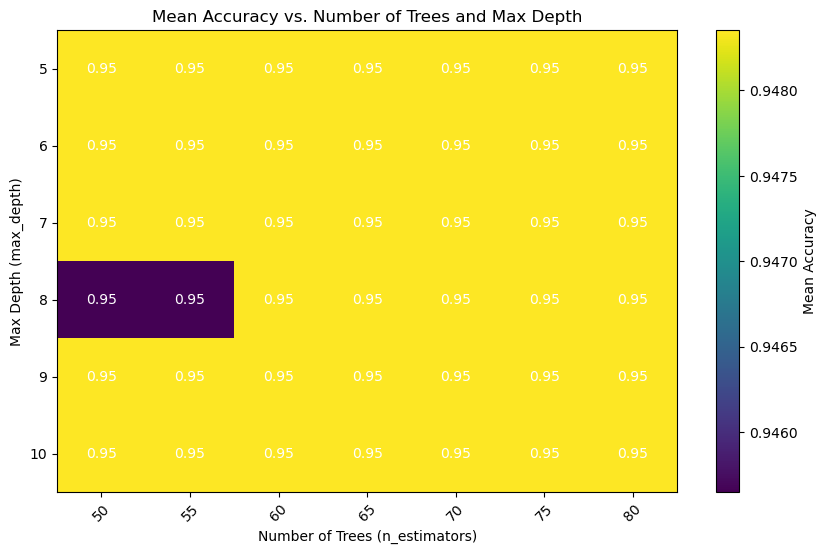

Test accuracy with best parameters: 0.8925


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
# Define the range of values for max_depth and n_estimators
max_depth_values = [5,6,7,8,9,10]
n_estimators_values = [50,55,60,65,70,75,80]

# List to store results and an array to store mean accuracies for visualization
results = []
mean_accuracies = np.zeros((len(max_depth_values), len(n_estimators_values)))
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search using cross-validation
for i, max_depth in enumerate(max_depth_values):
    for j, n_estimators in enumerate(n_estimators_values):
        # Initialize a RandomForest classifier with given max_depth and n_estimators
        rf_clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
        
        # Perform 5-fold cross-validation and compute mean accuracy
        cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=skf, scoring='accuracy')
        mean_accuracy = np.mean(cv_scores)
        
        # Store the mean accuracy in the array for visualization
        mean_accuracies[i, j] = mean_accuracy
        
        # Append the result to the list
        results.append({
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'mean_accuracy': mean_accuracy
        })

# Find the best combination of hyperparameters based on highest accuracy
best_result = max(results, key=lambda x: x['mean_accuracy'])
print(f"Best Parameters: max_depth={best_result['max_depth']}, n_estimators={best_result['n_estimators']}")
print(f"Best Cross-Validated Accuracy: {best_result['mean_accuracy']:.4f}")

plt.figure(figsize=(10, 6))
cax = plt.imshow(mean_accuracies, interpolation='nearest', cmap='viridis', aspect='auto')
plt.colorbar(cax, label='Mean Accuracy')
plt.xticks(np.arange(len(n_estimators_values)), n_estimators_values, rotation=45)
plt.yticks(np.arange(len(max_depth_values)), max_depth_values)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Max Depth (max_depth)')
plt.title('Mean Accuracy vs. Number of Trees and Max Depth')

for i in range(len(max_depth_values)):
    for j in range(len(n_estimators_values)):
        plt.text(j, i, f'{mean_accuracies[i, j]:.2f}', ha='center', va='center', color='white', fontsize=10)

plt.grid(False)
plt.show()

# Train the best RandomForest model with optimal parameters
best_rf_clf = RandomForestClassifier(max_depth=best_result['max_depth'], n_estimators=best_result['n_estimators'], random_state=42)
best_rf_clf.fit(X_train, y_train)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, best_rf_clf.predict(X_test))
print(f"Test accuracy with best parameters: {test_accuracy:.4f}")